<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_40).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Participacion electoral)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Participacion']]

In [5]:
df_var = df_sel.dropna()

In [6]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8541 entries, 0 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   8541 non-null   int64  
 1   Trimestre             8541 non-null   int64  
 2   Mes                   8541 non-null   int64  
 3   Codi_Districte        8541 non-null   int64  
 4   Nom_Districte         8541 non-null   object 
 5   Codi_Barri            8541 non-null   int64  
 6   Nom_Barri             8541 non-null   object 
 7   Compraventa_Unitario  8541 non-null   float64
 8   Participacion         8541 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 600.7+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [9]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Participacion
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,41.8
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,41.8
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,41.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Participacion
Fecha,,
2014-01-01,4198.150000,61.6
2014-02-01,4198.150000,61.6
2014-03-01,4198.150000,61.6
2014-04-01,4246.083333,61.6
2014-05-01,4246.083333,61.6


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2014-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  117 non-null    float64
 1   Participacion         117 non-null    float64
dtypes: float64(2)
memory usage: 2.7 KB


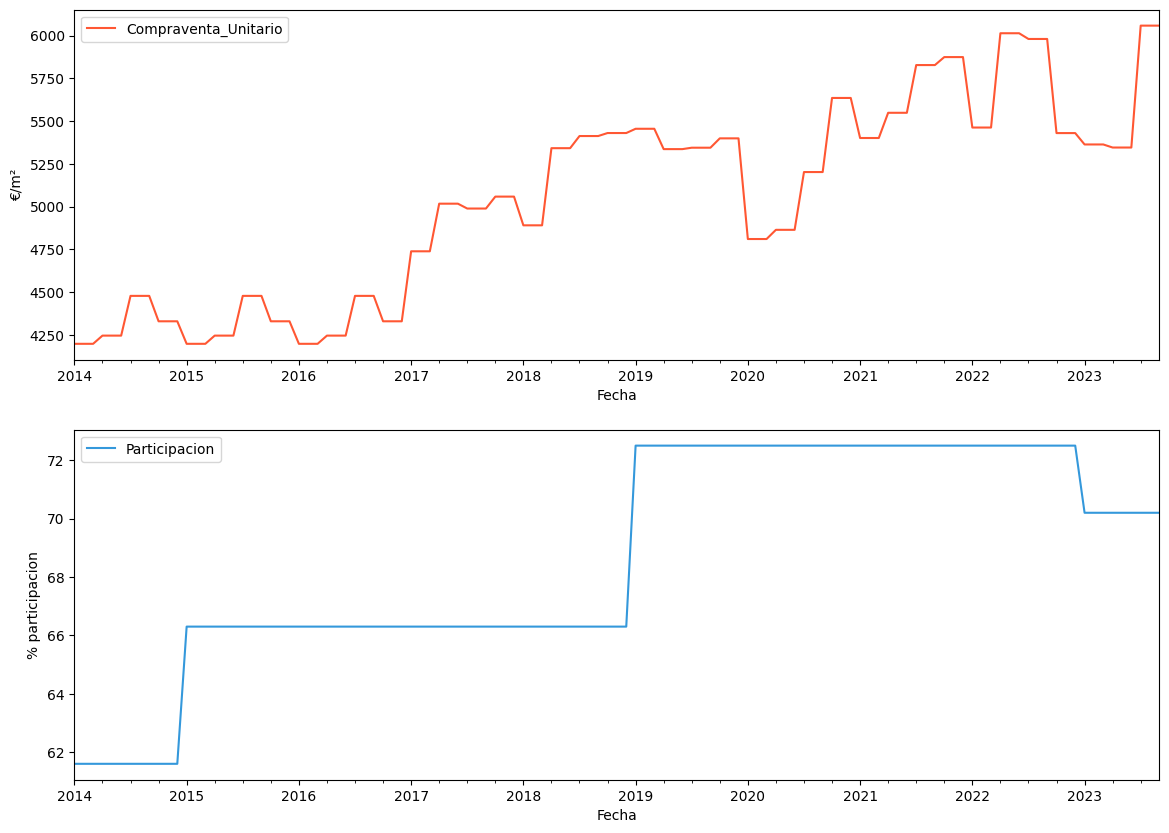

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% participacion']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Participacion
Compraventa_Unitario,1.000000,0.746986
Participacion,0.746986,1.000000


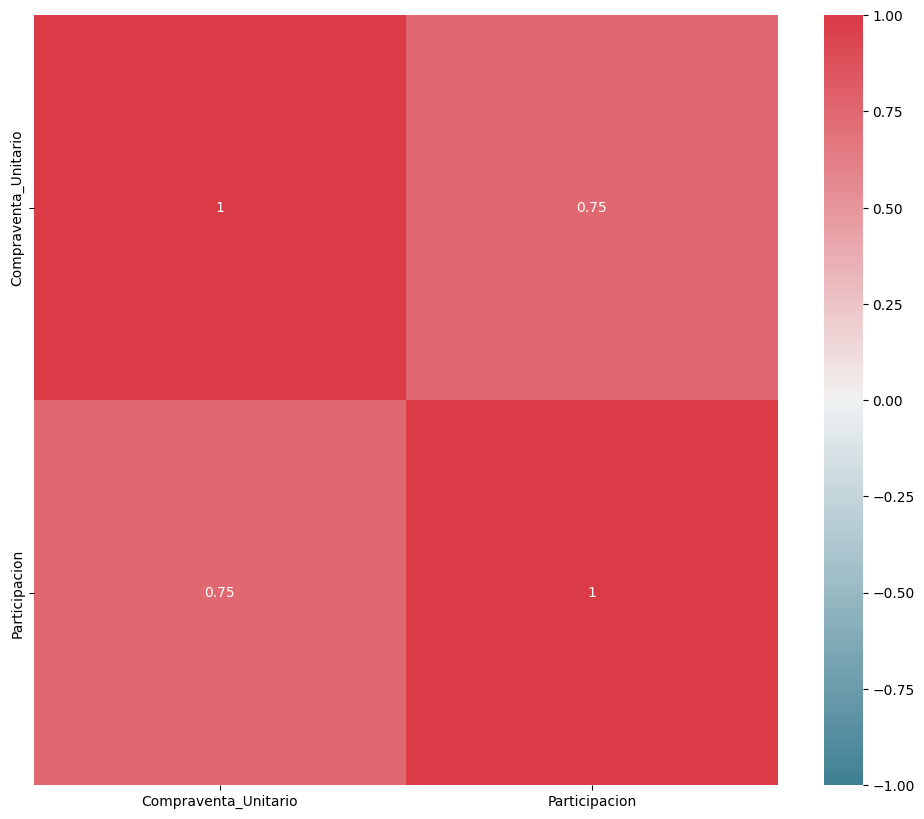

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Participacion" es de 0.746986, lo que sugiere una correlación positiva elevada entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(108, 2) (9, 2)


###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario', 'Participacion']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  8.32      > 12.3212   =>   False
Participacion >  3.58      > 4.1296    =>   False


- **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
- **Participacion** : Similarmente, "Participacion " tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.820608
Serie de tiempo Participacion
p-value: 0.498925


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Participacion
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,47.933333,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


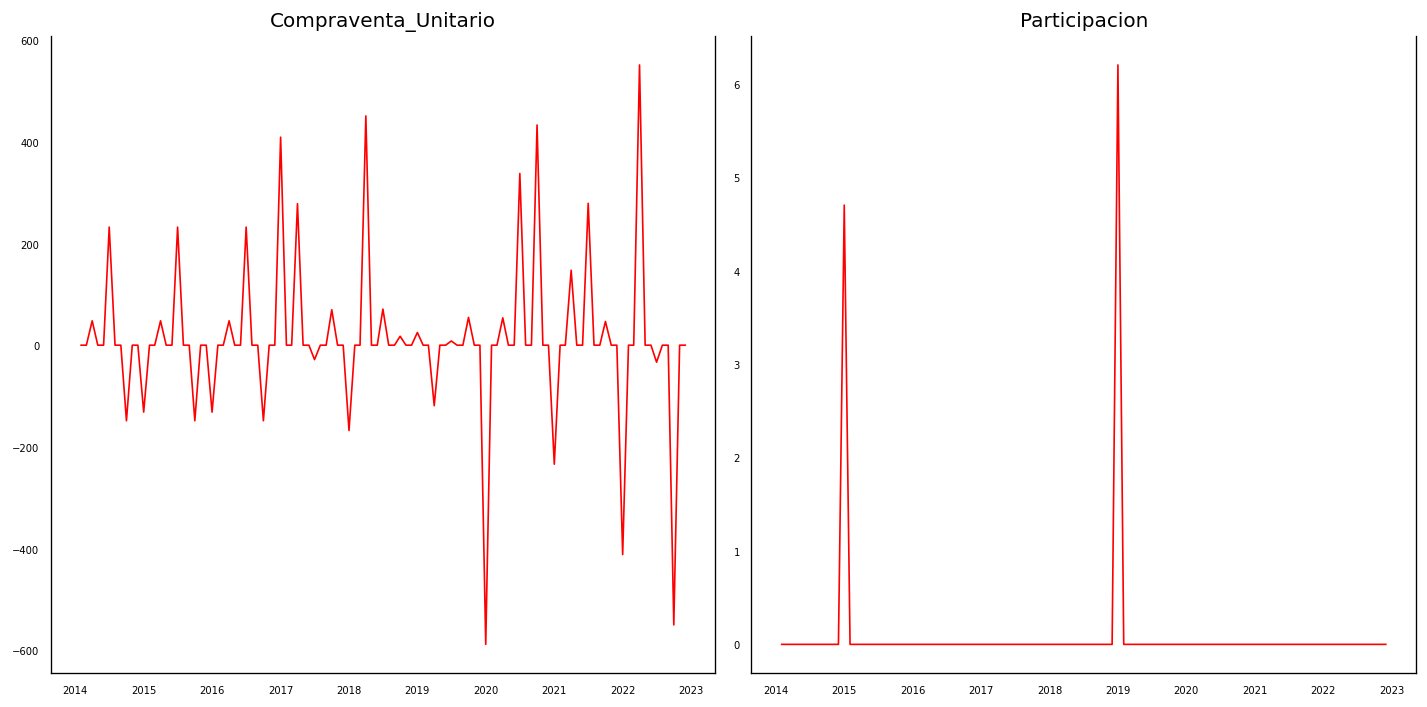

In [23]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Participacion
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.





In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

El término "select order" se refiere al proceso de selección del orden óptimo del modelo, es decir, el número adecuado de lags para incluir en el modelo VAR.

In [31]:
modelsel=model.select_order(24)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,9.428*,9.487*,1.244e+04*,9.452*
1,9.524,9.699,1.369e+04,9.595
2,9.620,9.912,1.507e+04,9.737
3,9.686,10.09,1.610e+04,9.849
4,9.781,10.31,1.772e+04,9.992
5,9.876,10.52,1.953e+04,10.13
6,9.847,10.60,1.901e+04,10.15
7,9.940,10.81,2.092e+04,10.29
8,10.03,11.02,2.303e+04,10.43
9,9.978,11.09,2.190e+04,10.42


En la selección de órdenes VAR, el criterio AIC y BIC son mínimos para un orden de 33. Sin embargo, se debe tener cuidado al interpretar estos resultados, ya que elegir un modelo con un número tan alto de parámetros puede conducir a problemas de sobreajuste y dificultades en la interpretación de los resultados.

Una estrategia prudente sería considerar también otros criterios, como el FPE y HQIC. Estos criterios también muestran mínimos para un orden de 33.

Para este caso escogeremos VAR(10)

#### Ajustando el modelo

In [49]:
res = model.fit(maxlags=23)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, May, 2024
Time:                     16:51:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.2052
Nobs:                     84.0000    HQIC:                   11.5785
Log likelihood:          -584.752    FPE:                    47832.8
AIC:                      10.4850    Det(Omega_mle):         19667.2
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                          160.193925        71.764840            2.232           0.026
L1.Compraventa_Unitario         -0.118616         0.163539           -0.725           0.468
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Participacion" es de -0.004970, lo que sugiere una correlación negativa fuerte entre los residuos de estas dos variables en el modelo.

In [50]:
res.is_stable()

True

In [51]:
X_train.columns

Index(['Compraventa_Unitario', 'Participacion'], dtype='object')

###### Causalidad de Granger

In [52]:
grangercaus=res.test_causality(['Participacion'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.4957,1.676,0.970,"(23, 74)"


In [53]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Participacion'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.308,1.676,0.193,"(23, 74)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

###### Matriz de causalidad de Granger


In [54]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=10
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Participacion_x
Compraventa_Unitario_y,1.000,0.9094
Participacion_y,0.192,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [55]:
residuals=res.resid

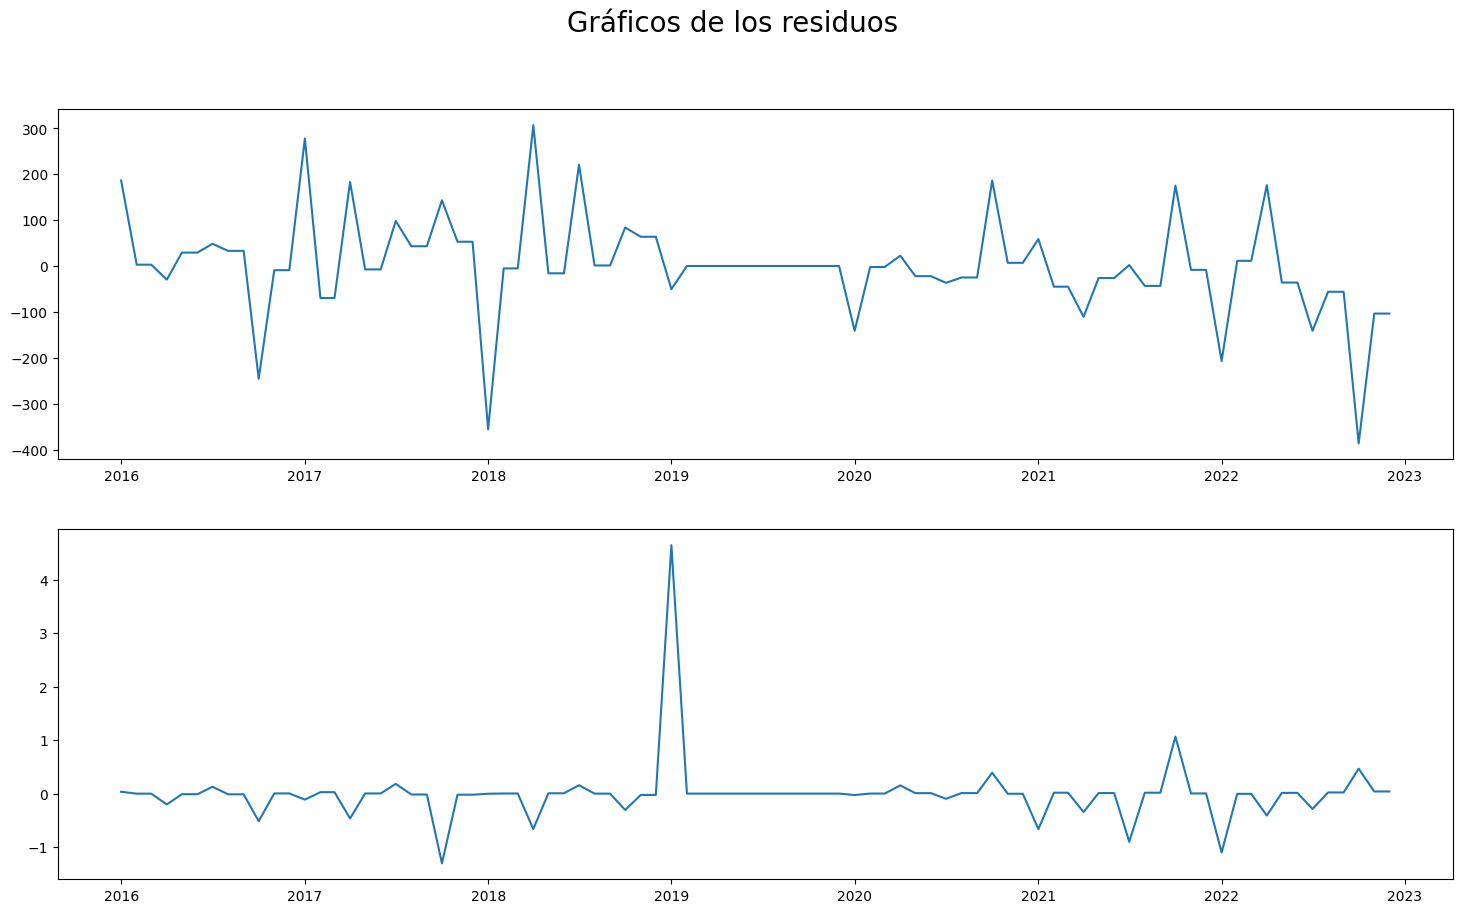

In [56]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [57]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[7.180489662550963e-14, 5.675496385321766e-15]

Para la primera serie de tiempo, el p-valor es aproximadamente 0.1146, lo que sugiere que no se puede rechazar la hipótesis nula de que hay una raíz unitaria en los residuos. Esto indica que los residuos pueden ser estacionarios.

Para la segunda serie de tiempo, el p-valor es muy pequeño (alrededor de 2.2036e-13), lo que indica que se rechaza la hipótesis nula de presencia de una raíz unitaria en los residuos. Por lo tanto, los residuos son estacionarios en este caso.



###### ACF de los Residuos


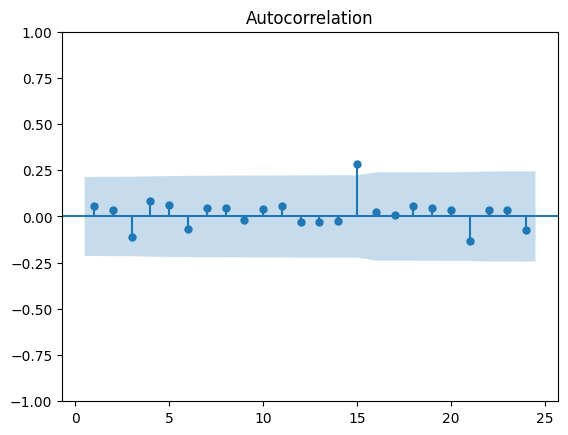

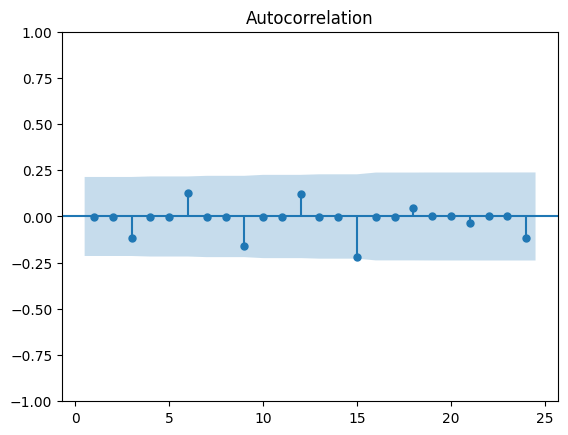

In [58]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 24) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 14, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 15 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:
- Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
- Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.



In [59]:
res = model.fit(15)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, May, 2024
Time:                     16:52:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.5171
Nobs:                     92.0000    HQIC:                   10.5036
Log likelihood:          -650.698    FPE:                    19389.1
AIC:                      9.81767    Det(Omega_mle):         10847.4
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           62.632104        23.942634            2.616           0.009
L1.Compraventa_Unitario         -0.086581         0.121177           -0.714           0.475
L

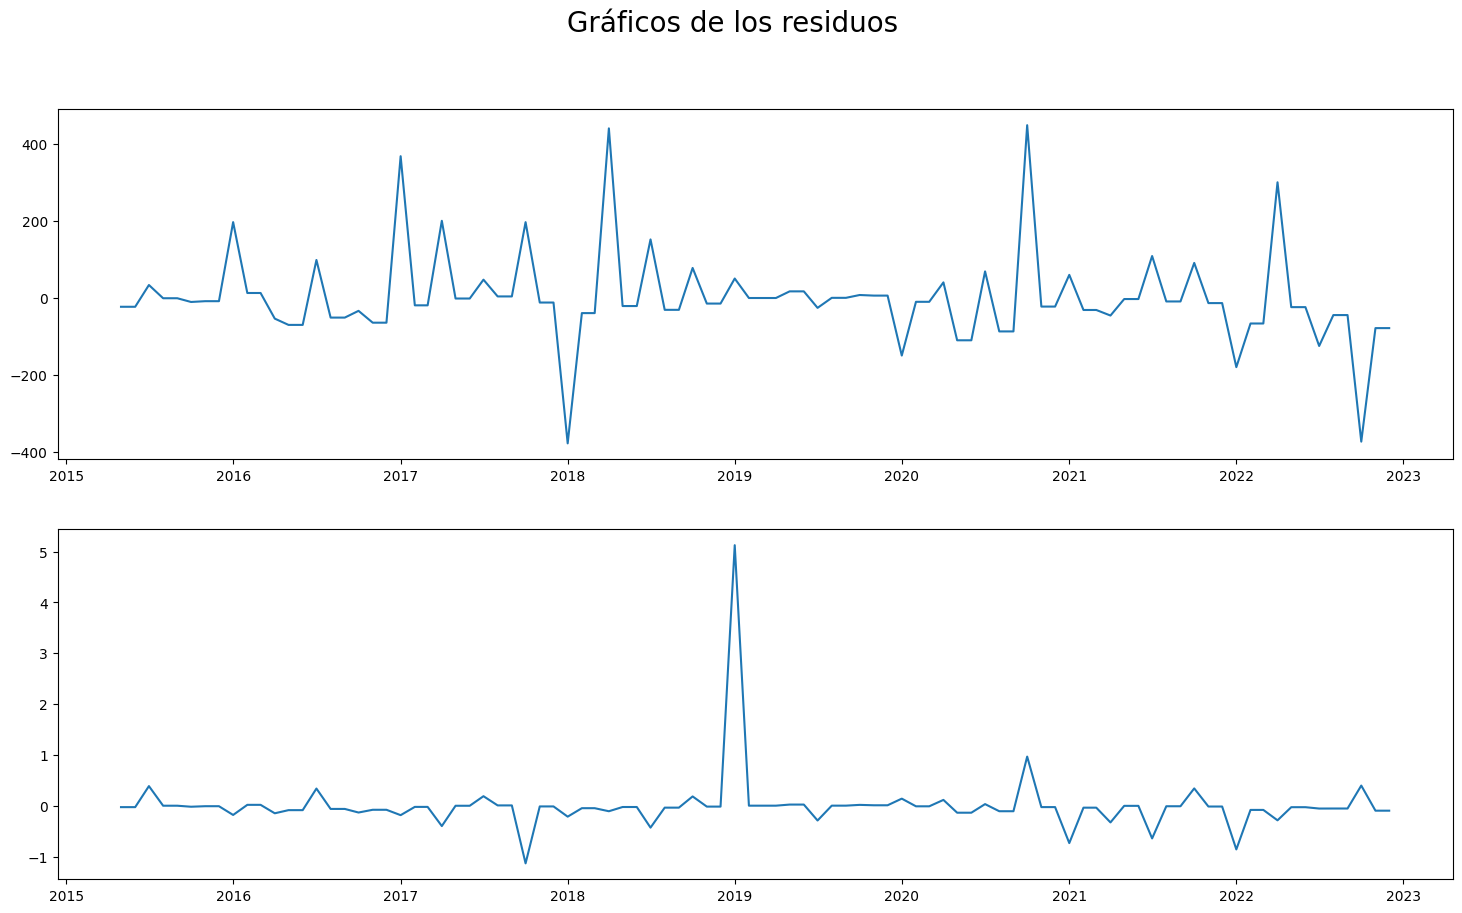

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

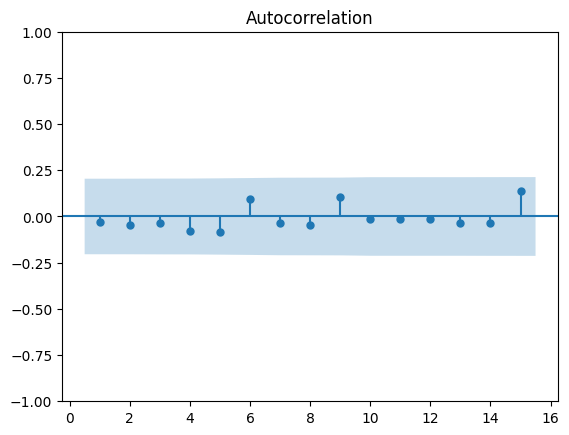

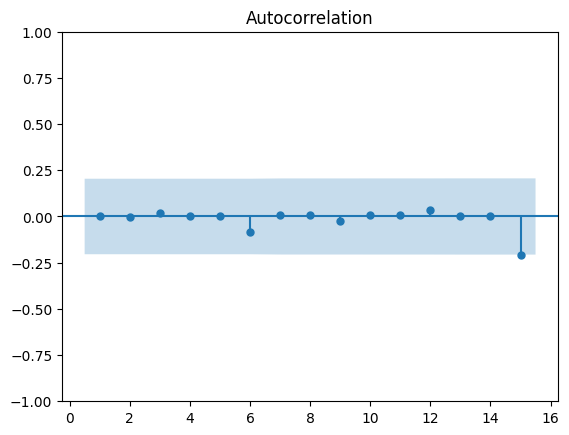

In [61]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 15) for i in range(2)]
plt.show()

#### Valores predichos


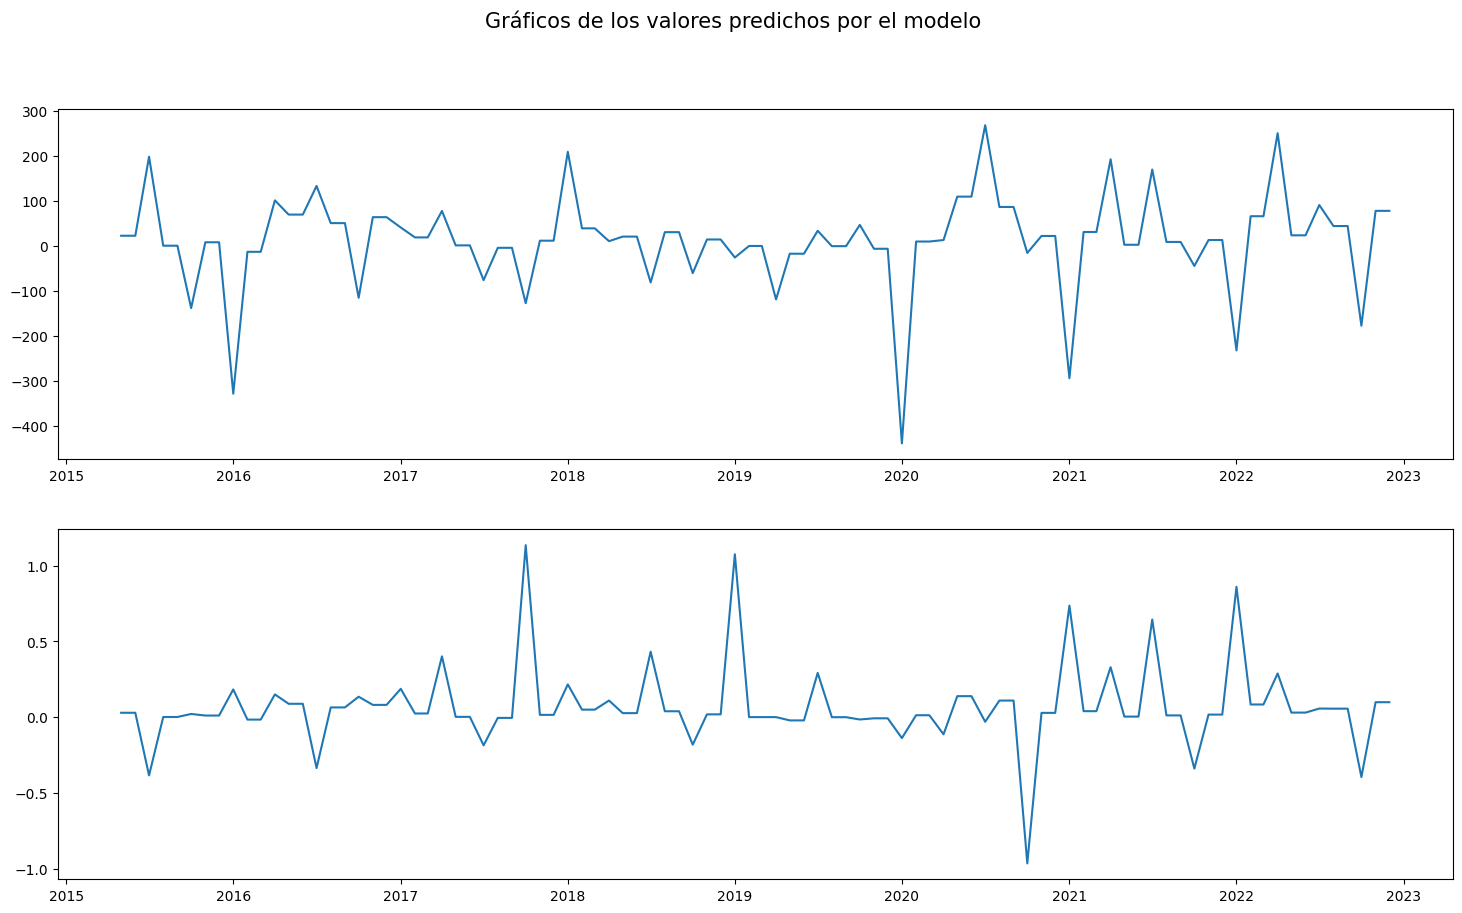

In [62]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [63]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 15
Predicciones:


,Compraventa_Unitario_pred,Participacion_pred
Fecha,,
2023-01-01,71.329091,1.306950
2023-02-01,87.502603,0.110248
2023-03-01,79.364283,0.099994
2023-04-01,399.325026,-0.715292
2023-05-01,16.132351,0.065918
2023-06-01,15.090737,0.060365
2023-07-01,-199.103917,-0.524191
2023-08-01,25.720351,0.094725
2023-09-01,23.078152,0.085839


<Figure size 1200x1000 with 0 Axes>

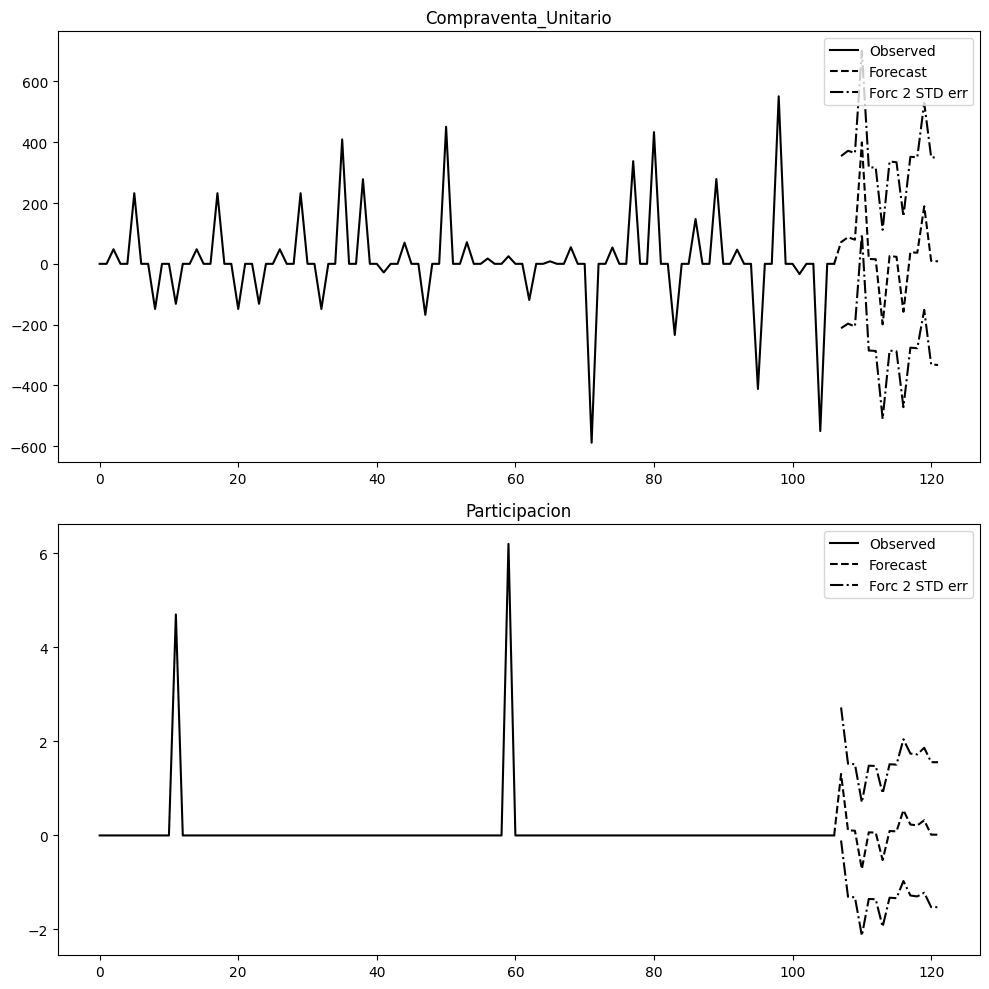

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [65]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [66]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Participacion
Fecha,,
2023-01-01,5501.312425,73.806950
2023-02-01,5588.815028,73.917198
2023-03-01,5668.179311,74.017193
2023-04-01,6067.504337,73.301901
2023-05-01,6083.636688,73.367819
2023-06-01,6098.727425,73.428184
2023-07-01,5899.623508,72.903993
2023-08-01,5925.343860,72.998718
2023-09-01,5948.422011,73.084558


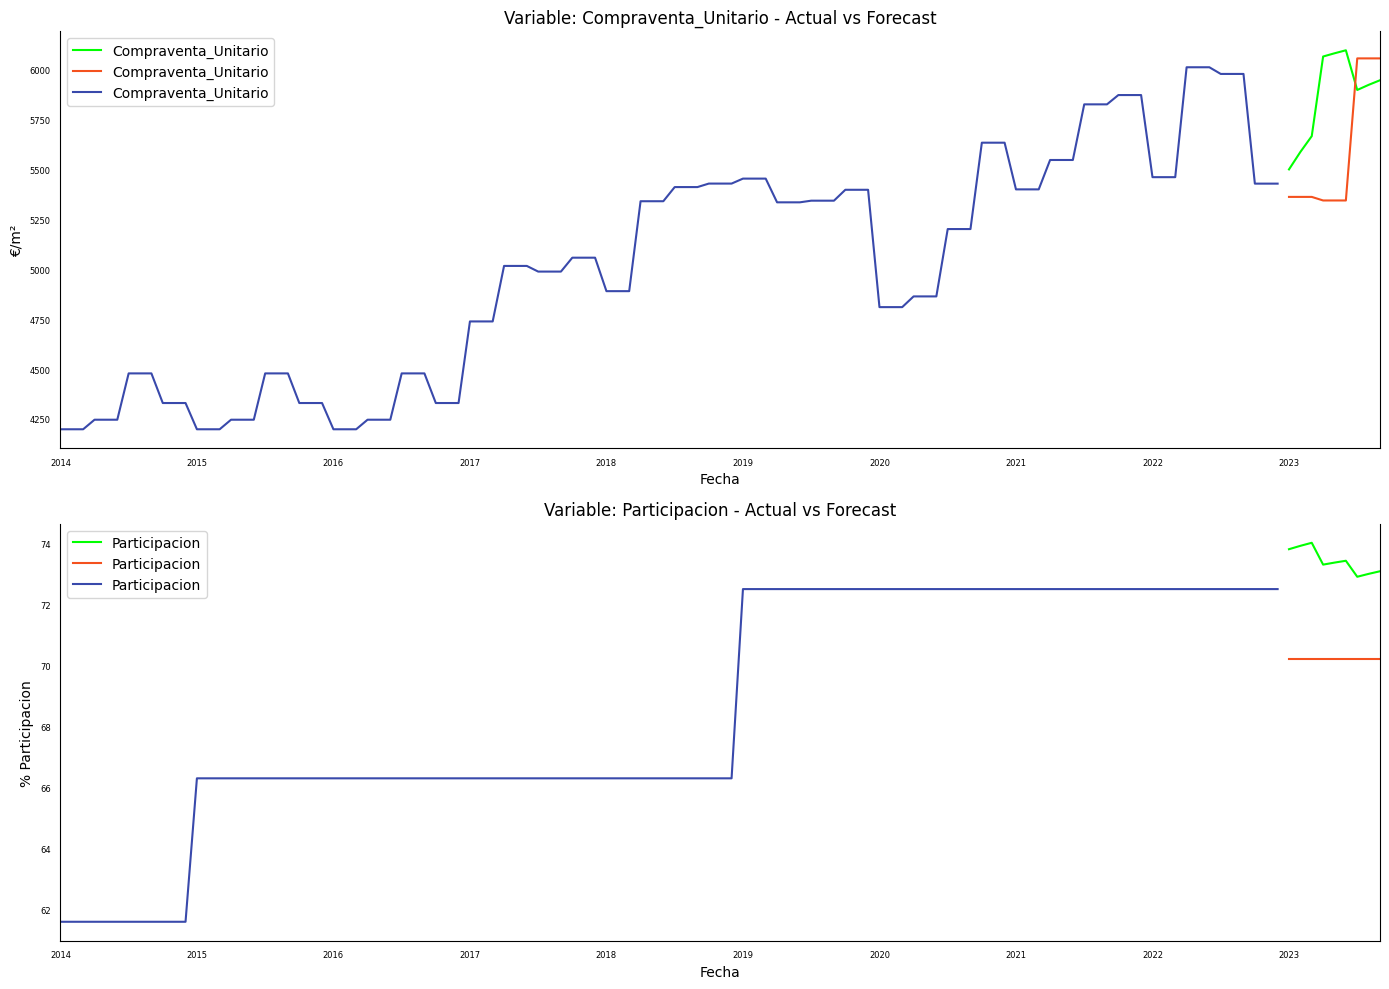

In [67]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Participacion']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [68]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [69]:
for i in ['Compraventa_Unitario','Participacion']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 205628.2532645937
MAE is : 364.66509271091644
RMSE is : 453.4625158318973
MAPE is : 6.719206077409319
R2 is : -0.8683719163642387

Evaluation metric for Participacion
Evaluation metric results:-
MSE is : 10.549080226248515
MAE is : 3.2251681461273907
RMSE is : 3.2479347632377893
MAPE is : 4.594256618415087
R2 is : 0.0



Los resultados de las métricas de evaluación indican que el modelo para predecir Compraventa_Unitario tiene un rendimiento deficiente, evidenciado por el valor negativo del R2 (-0.868), lo que sugiere que el modelo es peor que usar la media de los datos como predicción. La MSE alta (205628.25) y el RMSE (453.46) también reflejan una gran dispersión en las predicciones. La MAE (364.67) y MAPE (6.72%) sugieren que el error promedio absoluto es significativo.

Por otro lado, el modelo para predecir Participacion muestra un rendimiento moderadamente mejor. La MSE (10.55) y el RMSE (3.25) son relativamente bajos, indicando una mejor precisión en las predicciones. La MAE (3.23) y el MAPE (4.59%) también indican un error promedio absoluto menor. Sin embargo, el R2 de 0.0 muestra que el modelo no explica la variabilidad de los datos, sugiriendo una necesidad de mejora en ambos modelos.

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 183.9451304285219
Root mean squared error: 320.65464470737044


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.

In [71]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [72]:
import pmdarima as pm

In [73]:
pq = []
for name in ['Compraventa_Unitario', 'Participacion']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1375.770, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1377.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1377.770, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1379.770, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1377.125, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Participacion
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=244.696, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=246.696, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=246.696, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=248.696, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=244.715, Time=0.06 sec

Best model:  ARIMA(0,0,0

In [74]:
pq

[(0, 0, 0), (0, 0, 0)]

Los valores obtenidos para p y q en las dos series son 0, lo que:
- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMA no incluye dependencia de los valores pasados de las variables en sí mismas

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMA, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.


##Conclusiones

El análisis de series temporales realizado para predecir las variables "Compraventa_Unitario" y "Participacion" en el distrito de Sarrià-Sant Gervasi mediante modelos VAR y VARMA proporciona información relevante sobre la relación y predictibilidad de estas variables.

Primero, se evidenció una alta correlación positiva (0.746986) entre "Compraventa_Unitario" y "Participacion", lo que sugiere una interdependencia significativa. Sin embargo, las pruebas de cointegración mostraron que no hay una relación de equilibrio a largo plazo entre estas series. Asimismo, las pruebas de estacionariedad iniciales revelaron que ambas series no eran estacionarias, lo cual se corrigió mediante una diferenciación de primer orden.

El modelo VAR ajustado mostró que la causalidad de Granger no se encontró significativa en ninguna dirección entre las dos series, indicando que ninguna variable es un buen predictor de la otra. Los residuos del modelo mostraron en su mayoría estacionariedad y ausencia de autocorrelación significativa, excepto en ciertos rezagos, sugiriendo que el modelo estaba adecuadamente especificado en general.

Las métricas de evaluación para "Compraventa_Unitario" indicaron un desempeño deficiente del modelo (R2 de -0.868), mientras que para "Participacion" el rendimiento fue moderadamente mejor (R2 de 0.0). Estos resultados sugieren que el modelo VAR no logró capturar adecuadamente la variabilidad de las series, especialmente para "Compraventa_Unitario".

El intento de ajuste de un modelo VARMA a través de auto ARIMA no fue viable, ya que los valores óptimos para p y q resultaron ser cero, indicando la falta de términos autoregresivos y de medias móviles, lo que implica que el modelo no incorporó adecuadamente la autocorrelación en los residuos.

